In [6]:
import os
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import random

import matplotlib.pyplot as plt


In [8]:
books_combined = open('books_combined.txt').read()
print('length of all books combined: ', len(books_combined))

#work with a subset of the books
start_book_ind = 15000000
end_book_ind = 20000000
sub_books_combined = books_combined[start_book_ind: end_book_ind]
print('size of data: ', len(sub_books_combined))

char_to_int = {}
int_to_char = {}
#turn characters into integers and integers into characters - chars should be sorted to keep consistency
for i, char in enumerate(sorted(set(books_combined))):
    char_to_int[char] = i
    int_to_char[i] = char
    
print('number of unique characters: ', len(char_to_int)) #should be 48 every time




#returns a tensor for training
def get_train(book, sentence_length=50):
    sent = []
    next_c = []
    #get varying sentences of similar sizes - step for a size of 5 - 5 is an arbitraily chosen number
    for i in range(0, len(book)-sentence_length, 2):
        begin_char = i
        end_char = i+sentence_length
        #combine sentence to a sentence list
        sent.append(book[begin_char: end_char])
        #get the next character after the sentence
        next_c.append(book[end_char])

    print(sent[:5])
    print(next_c[:5])

    #turn into Tensors for training the model - using one hot encoding method
    # 1 if char in sentence and 0 otherwise
    unique_c_length = len(set(book)) # number of unique characters in text
    num_sent = (len(sent)) #numer of sentences created
    x = np.zeros((num_sent, sentence_length, unique_c_length), dtype=np.int8)
    y = np.zeros((num_sent, unique_c_length), dtype=np.int8)

    for i, sentence in enumerate(sent):
        for k, c in enumerate(sentence):
            c_ind = char_to_int[c]
            x[i, k, c_ind] = 1

        next_c_ind = char_to_int[next_c[i]]
        y[i, next_c_ind] = 1


    return x,y
  
  
  

sentence_length = 50
num_unique_chars = len(set(books_combined))
print("sentence_length: ", sentence_length)
print("num unique_chars: ", num_unique_chars)

#create tensors
x, y = get_train(sub_books_combined, sentence_length=sentence_length)
print(x.shape)
print(y.shape)





length of all books combined:  74454677
size of data:  5000000
number of unique characters:  48
sentence_length:  50
num unique_chars:  48
[" knew that madame ratignolle's opinion in such a m", "new that madame ratignolle's opinion in such a mat", "w that madame ratignolle's opinion in such a matte", "that madame ratignolle's opinion in such a matter ", "at madame ratignolle's opinion in such a matter wo"]
['a', 't', 'r', 'w', 'u']
(2499975, 50, 48)
(2499975, 48)


In [3]:
#save models that perform best
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

#create network
model = Sequential()
#128 nodes are used b/c the current network is small
model.add(LSTM(128, input_shape=(sentence_length, num_unique_chars)))
model.add(Dropout(0.2))
# model.add(LSTM(128))
# model.add(Dropout(0.2))
#add the output layer
model.add(Dense(num_unique_chars, activation='softmax'))
#load previous weights
weights_filename = 'models/round4/model_4.h5'
model.load_weights(weights_filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

model.fit(x, y, epochs=50, batch_size=128, callbacks=[checkpoint])

Epoch 1/50
698752/999990 [===================>..........] - ETA: 6:32 - loss: 1.4459

KeyboardInterrupt: 

In [10]:
#creates new sentence
def create_passage(model):
    #complete passage string
    gen_sentence = ''

    #create sentence
    start_ind = random.randint(0, len(sub_books_combined) - sentence_length - 1)
    sentence = sub_books_combined[start_ind: start_ind+sentence_length]
    gen_sentence += sentence
    print('original sentenc: ', sentence)

    for i in range(500):
    #turn sentence into model format
        x_pred = np.zeros((1, sentence_length, len(char_to_int)))
        for k, c in enumerate(sentence):
            x_ind = char_to_int[c]
            x_pred[0, k, x_ind] = 1

        #predict next character - returns predicted probabilities
        prob_c = model.predict(x_pred, verbose=0)[0]
        #turn to float64 - mulitnomial gives error otherwise
        prob_c = np.asarray(prob_c).astype('float64')
        #     print(prob_c)
        #sample from the probability 
        log_prob = np.log(prob_c) / 0.5
        #     print(log_prob)
        exp_prob = np.exp(log_prob)
        #     print(exp_prob)
        pred_prob = exp_prob/np.sum(exp_prob)
        #     print(pred_prob)
        p = np.random.multinomial(1, pred_prob, 1) 
        #     print(p)
        prob_ind = np.argmax(p)
        #     print(prob_ind)




        #turn int to character
        next_c = int_to_char[prob_ind]
        #add character to generated sentence
        gen_sentence += next_c
        #     print(gen_sentence)
        #get new sentence by sliding to index of sentence
        sentence = sentence[1:]+next_c


    return gen_sentence

In [ ]:
#test out creating a passage using some of the passage within the books
print(create_passage(model))

original sentenc:  sly          stirred us to glory and gave me these<br>
sly          stirred us to glory and gave me these of the sense of the strong and being in a state and the street the soul for the spoken to scarne the fire destroyed and with the subjects best notice and absolute stream by the death of a contrary of the concerning the supportions is been ever known to the interest of the carriage in the man project gutenberg-tm electronic works in a most common-wealth and one of one final and the more not one of the wants of the consequence where the present stood the other were the small and project gutenberg

In [13]:
# serialize model to JSON
model_json = model.to_json()
with open("model_4_architecture.json", "w+") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_4.h5")
print("Saved model to disk")

Saved model to disk


In [21]:
history_dict = model.history.history

In [24]:
history_dict['loss']

38

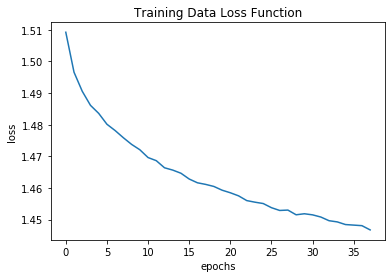

In [32]:
plt.plot(range(38), history_dict['loss'])
plt.title('Training Data Loss Function')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
# load json and create model architecture
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

In [ ]:
# evaluate loaded model on test data/ predict
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))